In [1]:
# Uncomment and download neccessary libarys if needed
# ! pip install wordcloud
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [2]:
# import librarys
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk.stem as stemmer
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
import re
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import collections
from gensim.models.phrases import Phrases, Phraser

In [3]:
# import librarys needed for our model
from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load our cleaned up data
df = pd.read_csv('../clean_lyrics_df.csv')

In [6]:
# Reference to available artist to run our model on
top_artist = ['frank sinatra', 'elvis presley', 'dolly parton', 'lil wayne',
       'chris brown', 'guided by voices', 'prince', 'johnny cash', 'bob dylan',
       'george jones', 'neil young', 'bruce springsteen', 'snoop dogg',
       'eminem', '50 cent', 'roy orbison', 'ella fitzgerald', 'taylor swift',
       'waylon jennings', '2pac tupac shakur', 'bb king', 'bon jovi',
       'george strait', 'madonna', 'diana ross', 'bill monroe', 'beach boys',
       'barry manilow', 'alice cooper', 'nas', 'ray charles', 'beck']

In [7]:
# Further text cleaning for topic modeling
def remove_dup_lines(lyrics):
    lyric_lines = lyrics.splitlines()
    unique_lines = []
    for line in lyric_lines:
        if line not in unique_lines:
            unique_lines.append(line.replace('.','').replace(',',''))
    clean_song = '\n'.join(unique_lines)
    return clean_song
df.Lyric = df.Lyric.apply(lambda x: remove_dup_lines(x))

In [8]:
df.head()

,ALink,SName,SLink,Lyric,language
0,50 cent,In da Club,/50-cent/in-da-club.html,go go go go\ngo go go shawty\nit's your birthd...,en
1,50 cent,21 Questions,/50-cent/21-questions.html,new york city!\nyou are now rappingwith 50 cen...,en
2,50 cent,P.I.M.P.,/50-cent/p-i-m-p.html,i don't know what you heard about me\nbut a b*...,en
3,50 cent,Many Men (Wish Death),/50-cent/many-men-wish-death.html,man we gotta go get something to eat man\ni'm ...,en
4,50 cent,Candy Shop,/50-cent/candy-shop.html,yeah\nuh huh\nso seductive\ni'll take you to t...,en


### NMF Model

In [9]:
class artist_wordcloud:
    
    def __init__(self,name):
        # Create Class with an artist name
        self.name = name
        self.SEED = 42
        self.df = None
        self.text = None
        self.dict = None
        self.corpus_tfidf = None
        self.model = None
        self.best_n_topics = None
        self.most_dom_topic = None
    
    def nmf_inputs(self):
        # Further cleans the data to remove duplicate lines, empty, lines, stopwords, etc.
        
        def preprocess_song(lyrics):
            # Define stopwords
            stop_words_list = stopwords.words('english')
            additional_stop_words = ["i'm", "i'll", "i've", "i'd", "we've", "we're","we'll", "we'd", "gonna",
                                     "wanna", "that's", "it's", "they're", "they've", 
                                     "wasn't", "would've","could've", "they'll",
                                     "i've", "ooh", "yeah","chorus", "verse","thats"]
            stop_words_list += additional_stop_words
            preproc= WordNetLemmatizer().lemmatize

            cleaned_text = []
            text = lyrics.split('\n') # slit by lines and sentences
            text = [x for x in text if len(x) > 0] # remove empty lines
            for line in text:
                line_words = re.findall(r"\w+\*{0,5}'?\w*", line)
                for word in line_words:
                    cleaned_text.append(preproc(word))
            cleaned_text = [x for x in cleaned_text if (x not in stop_words_list) and (len(x)>2) ]

            return cleaned_text

        # Define local variables
        self.df = df[df.ALink == self.name].copy()
        lemma= WordNetLemmatizer()
        
        text = [preprocess_song(x) for x in self.df.Lyric]
        phraser_model = Phrases(text, min_count = 1, scoring = 'npmi', threshold= .8)
        phraser = phraser_model.freeze()
        self.text = [phraser[x] for x in text]
        
        art_dict = Dictionary(self.text)
        art_dict.filter_extremes(no_below = 3, no_above=.4, keep_n = None)
        self.dict = art_dict
        
        corpus = [self.dict.doc2bow(x) for x in self.text]
        tfidf = TfidfModel(corpus)
        self.corpus_tfidf = tfidf[corpus]
    
    def coherence_computation(self, min_topics, max_topics, coherence ='c_v'):
        # compute optimal topic count to use for our NMF Model
        # plot line chart for observations
    
        ntopic_coher = {'n_topics':[], 'coherence': []}

        for num_topics in range(min_topics, max_topics+1):
            model = Nmf(self.corpus_tfidf, num_topics= num_topics, random_state = self.SEED, id2word = self.dict)
            coherencemodel = CoherenceModel(model=model, texts=self.text, dictionary=self.dict, topn = 10, coherence=coherence)
            ntopic_coher['n_topics'].append(num_topics)
            ntopic_coher['coherence'].append(coherencemodel.get_coherence())
        
        # save best number of topics to use
        self.best_n_topics = ntopic_coher['n_topics'][ntopic_coher['coherence'].index(max(ntopic_coher['coherence']))]
        
        plt = pd.DataFrame(ntopic_coher).set_index('n_topics').plot(
            ylabel = 'Coherence',
            xlabel= 'Number of Topics', 
            title = 'NMF Average Coherence Score ({})'.format(self.name))
        return ntopic_coher
    
    def topic_model(self):
        # Returns topic words and saves model with best topic count
        
        self.model = Nmf(self.corpus_tfidf, num_topics= self.best_n_topics, random_state = self.SEED, id2word = self.dict)

        term_list = self.model.top_topics(corpus = self.corpus_tfidf, texts = self.text, topn=10, coherence = 'c_v')
        return term_list
    
    
    def get_dominant_topic(self):
        # Maps actual songs to a topic and returns most dominant topic number
        
        corpus_bow = [self.dict.doc2bow(x) for x in self.text]
        doc_top_list = list(self.model.get_document_topics(bow=corpus_bow))

        top_doc = []
        for d in doc_top_list:
            if len(d) == 1:
                top_doc.append(d[0][0])
            else:
                d.sort(key=lambda x: x[1], reverse = True)
                top_doc.append(d[0][0])

        counter = collections.Counter(top_doc)
        self.most_dom_topic = counter.most_common(1)[0][0]
        return self.most_dom_topic
    
    def show_best_topic(self):
        # Creates word cloud for most dominant topic
        
        # return coherence scores and topic with words
        term_scores = self.model.show_topic(topicid = self.most_dom_topic, topn=30)
        wc_inputs = {word:freq for word, freq in term_scores}
        
        import warnings
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        import PIL
        from PIL import Image
        g_mask = np.array(Image.open("guitar.png"))
        g_mask = g_mask[200:-60,400:800]

        def transform_format(val):
            if val >= 100:
                return 255
            else:
                return 0

        g_trans = np.ndarray((g_mask.shape[0],g_mask.shape[1]), np.int32)
        for i in range(len(g_mask)):
            g_trans[i] = list(map(transform_format, g_mask[i]))

        wc = WordCloud(background_color='dimgrey',contour_width=3, contour_color='dimgrey', mask= g_trans).fit_words(wc_inputs)
        wc_clean = np.array(wc)
        wc_clean[g_trans ==255] = 255

        name = " ".join(x.capitalize() for x in self.name.split())
        plt.figure(figsize = (40,18));
        plt.imshow(wc_clean);
        plt.xticks([])
        plt.yticks([])
        for pos in ['right', 'top', 'bottom', 'left']:
            plt.gca().spines[pos].set_visible(False)
        plt.ylabel("{}'s Most Dominant Topic (NMF)".format(name), fontsize=36, fontweight='bold')
        plt.show()

### Execute in the following order:
    model = artist_wordcloud( enter_artist_name )
    model.nmf_inputs()
    model.coherence_computation(min_topics = 2, max_topics = 10)
    model.topic_model()
    model.get_dominant_topic()
    model.show_best_topic()

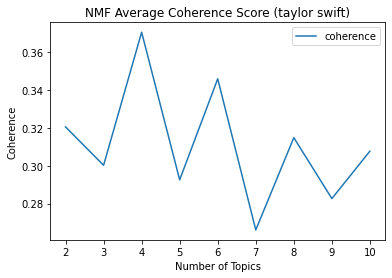

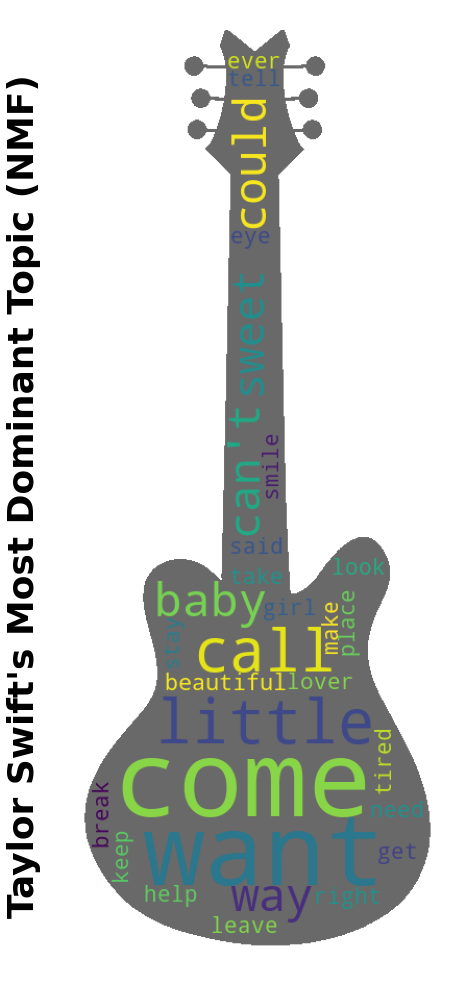

CPU times: total: 3.73 s
Wall time: 15.9 s


In [10]:
%%time
ts= artist_wordcloud('taylor swift')
ts.nmf_inputs()
ts.coherence_computation(min_topics = 2, max_topics = 10)
ts.topic_model()
ts.get_dominant_topic()
ts.show_best_topic()

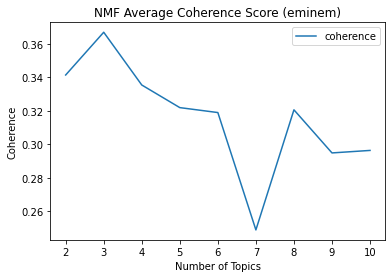

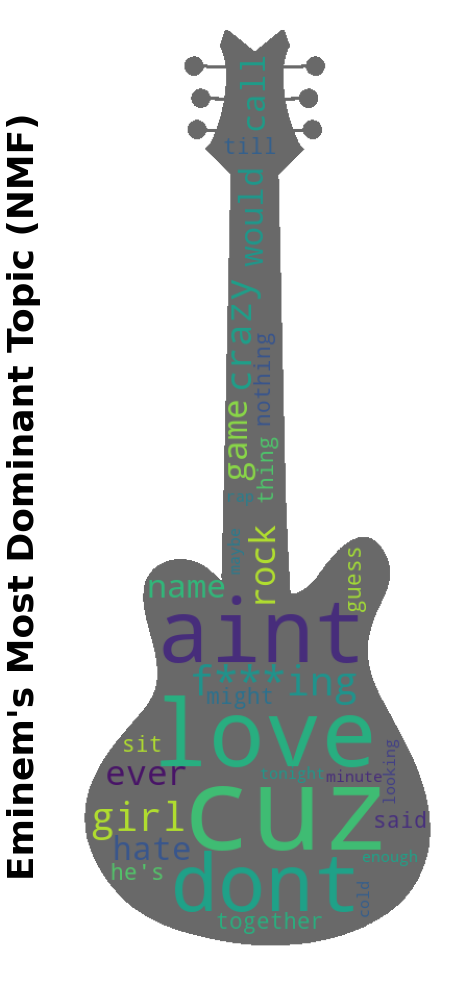

CPU times: total: 5.16 s
Wall time: 33.1 s


In [11]:
%%time
em = artist_wordcloud('eminem')
em.nmf_inputs()
em.coherence_computation(min_topics = 2, max_topics = 10)
em.topic_model()
em.get_dominant_topic()
em.show_best_topic()